PROJECT 2: Data Mining: fake news detection within online social media


### 

for the slides presentation: https://www.youtube.com/watch?v=cEQXTsZrf8g


In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import string
import nltk
from stop_words import get_stop_words
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize

from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [3]:
# dataset 
# we will be using the  buzz feed news  on twitter as dataset

# What we plan on doing is to predict if a news is fake or real based on the words in the title and the text content (body)/ 
# then, what we want to do is give more weight to the words in the title and redo the process, 
# using random forest algorithms




In [88]:
# loading dataset: we have real and fake one
df_real=pd.read_csv('gossip_full_real.csv')
print(df_real.shape)
df_fake=pd.read_csv('gossip_full_fake.csv')
print(df_fake.shape)

(116, 5)
(114, 5)


In [89]:
# concatenating the two dataframes
data = pd.concat([df_fake,df_real], axis =0)
print(data.shape)
data.head(4)

(230, 5)


,news_url,title,text,source,type
0,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,Home U.K. News Sports U.S. Showbiz Australia F...,www.dailymail.co.uk,fake
1,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,NaN,hollywoodlife.com,fake
2,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,× Plus Icon Click to expand the Mega Menu Plus...,variety.com,fake
3,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,Home U.K. News Sports U.S. Showbiz Australia F...,www.dailymail.co.uk,fake


In [90]:
# data summary 
data.describe()

,news_url,title,text,source,type
count,230,230,193,230,230
unique,229,229,188,132,2
top,www.lifeandstylemag.com/posts/katie-holmes-jam...,"Jamie Foxx Is ""Upset"" That Katie Holmes and Jo...",Continue to Hollywoodlife () SKIP AD Hollywood...,people.com,real
freq,2,2,3,14,116


In [91]:
# we can already see that among the titles, there are 5 duplicates
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230 entries, 0 to 115
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   news_url  230 non-null    object
 1   title     230 non-null    object
 2   text      193 non-null    object
 3   source    230 non-null    object
 4   type      230 non-null    object
dtypes: object(5)
memory usage: 10.8+ KB


In [92]:
# cleaning the data and extracting features:

# checking missing and null values
print(data.isna().sum())



news_url     0
title        0
text        37
source       0
type         0
dtype: int64


In [93]:
# droping the columns without text
data.dropna( inplace=True )
data.reset_index(drop=True, inplace=True)


In [98]:
#real_order

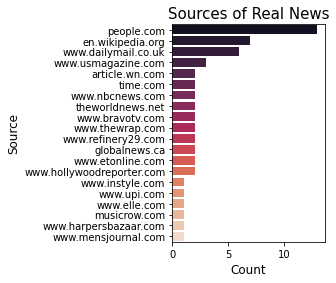

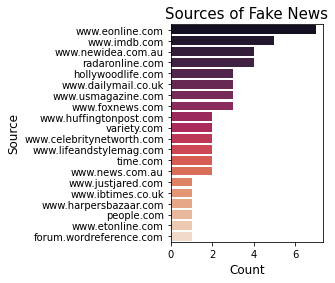

In [97]:
# now, let"s look at the source and see the difference between the real and fake sources
real_order=data[data['type']=='real']['source'].value_counts().sort_values(ascending=False).index
fake_order=data[data['type']=='fake']['source'].value_counts().sort_values(ascending=False).index

# subplot for the real sources
plt.subplot(1, 2, 1) 
#plt.figure(figsize=(10,6))
sns.countplot(y='source', data=data[data['type']=='real'],order=real_order[0:20],palette='rocket')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Real News',fontsize=15)
plt.show()

# subplot for the fake sources
plt.subplot(1, 2, 2) 
#plt.figure(figsize=(10,6))
sns.countplot(y='source', data=data[data['type']=='fake'],order=fake_order[0:20],palette='rocket')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.title('Sources of Fake News',fontsize=15)

plt.show()


In [12]:
#data[data['type']=='fake']['source'].unique()

In [99]:
# let's check the sources that publish both fake and real news
both_sources =[]
for i in data[data['type']=='fake']['source'].unique():
    if i in data[data['type']=='real']['source'].unique():
        both_sources.append(i)

print(both_sources)

['www.dailymail.co.uk', 'variety.com', 'en.wikipedia.org', 'www.usmagazine.com', 'www.hollywoodreporter.com', 'www.express.co.uk', 'www.thewrap.com', 'onairwithryan.iheart.com', 'www.usatoday.com', 'time.com', 'www.harpersbazaar.com', 'people.com', 'www.cnn.com', 'www.aol.com', 'www.esquire.com', 'www.etonline.com', 'www.independent.ie']


In [100]:
# let's plot the common sources with their ratio of real and fake news:
data['common']= data['source'].apply(lambda x: x if x in both_sources else 0 )

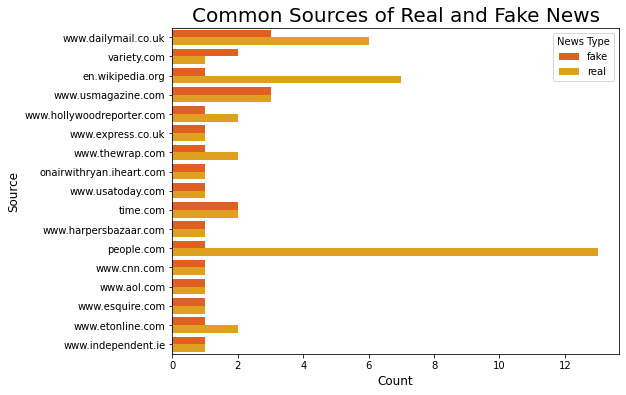

In [101]:
plt.figure(figsize=(8,6))
sns.countplot(y='common',data=data[data['common']!=0],hue='type',palette='autumn')
plt.xlabel('Count',fontsize=12)
plt.ylabel('Source',fontsize=12)
plt.legend(loc='best', title='News Type',fontsize=10)
plt.title('Common Sources of Real and Fake News',fontsize=20)
plt.show()

In [19]:
# preprocessing of the title and text of news articles....
# For this, we are going to :
 # convert text to lower case
 # remove numbern punctuation, extra spaces, special characters from the text corpus
 # removing stop words
 # stemming words to root


In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vickyyounang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vickyyounang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vickyyounang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [103]:
# preprocessing function:

ps = PorterStemmer()
wt = WhitespaceTokenizer()

def preprocess_text(text):
    
    #text = ''
    #removing the stopwords
    
    #wordlist = word_tokenize(x)
    
    wordlist = word_tokenize(text)
    #print(wordlist)
    
    # lower
    text = [ word.lower() for word in wordlist]
    
    stop_words = list(get_stop_words('en'))         #About 900 stopwords
    nltk_words = list(stopwords.words('english')) #About 150 stopwords$
    stop_words.extend(nltk_words)
    filtered_words = [word for word in text if word not in stop_words]
    #print(filtered_words)
    
    
    # removing special char 
    text = [word for word in filtered_words if (word.isalnum()==True) or (word==' ') ] 
    #print(text)
    
    #removing special characters and punctuation
    #text = text.translate(str.maketrans('', '', string.punctuation))
    #text = [word for word in text if word not in string.punctuation]
    #text = [word.translate(str.maketrans('', '', string.punctuation)) for word in text]
    text = [word for word in text if word not in string.punctuation]
    #text2 = [word.translate(str.maketrans('', '', string.punctuation)) for word in text]
    #wordlist = word_tokenize(text)
    
    #REMOVING NUMBERS
    text = str(' ').join([i for i in text if not i.isdigit()])
    
    
    
    
    #for sentence in intext:
    #    text = text+' '+sentence
    
    #print(text)
    # stemming the input words:
    #psstem = [ps.stem(a) for a in text]
    psstem = ps.stem(text)
    #text = ' '.join(psstem)
     
    # removing spaces and getting only words:
    text = wt.tokenize(psstem)
    #print(text)
     
    
    
    
    
    
    #print(text)
    # lower case
    out = ''
    for word in text:
        out = out+word.lower()+' '
    #text = [ word.lower() for word in text]
    #text = text.lower() 
    
    # print (out)
    
    return out



In [104]:
test = ['Proof The Mainstream Media Is Manipulating The Election By Taking Bill Clinton Out Of Context']

In [105]:
a=[]

for line in test:
    a.append(preprocess_text(line))

#a

In [106]:
# getting the count per words given the dataset:
def count_words(dataset):
    
    # preprocessing the dataset
    dat_tit =[]
    for line in dataset:
        dat_tit.append(preprocess_text(line))
    
    # vectorising the output by wounts
    countvect = CountVectorizer( ).fit( dat_tit)
    df_title = countvect.transform(dat_tit)
    print(pd.DataFrame(df_title.todense()).shape)
    
    # getting the sum for each word
    new1=[]
    for x in range(0,pd.DataFrame(df_title.todense()).shape[1]):
        new1.append(countvect.get_feature_names()[x])

    # tdf matrix
    matrix=pd.DataFrame(df_title.todense(),columns=new1)

    # sum for representation
    sm1=[]
    for x in new1:
        sm1.append(matrix[x].sum())

    trans=matrix.transpose()
    trans['sum']=sm1
    top=trans.sort_values(by='sum', ascending=False)
    
    return top
    
    
    
    

In [107]:
# analysze title of fake and real news
# here, the goal is to bring out the firsr top 25 topics of the different articles in their titles

# fake
df_fake=data[data['type']=='fake']

print(df_fake['title'].shape)
#type(df_fake['title'])

top_fake_20=count_words(df_fake['title']).head(20)

(92,)
(92, 500)


/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [108]:
# for the real dataqet

df_real=data[data['type']=='real']

print(df_real['title'].shape)
#type(df_fake['title'])

top_real_20=count_words(df_real['title']).head(20)

(101,)
(101, 623)


In [44]:
#top_real_20

In [109]:
# merging the fake and real top 20

#let's drop the useless columns, those not the sum
top_fake_20.drop(list(range(0,df_fake['title'].shape[0])),axis=1,inplace=True)
top_real_20.drop(list(range(0,df_real['title'].shape[0])),axis=1,inplace=True)

# adding a category column
top_real_20['type']='real'
top_fake_20['type']='fake'


In [110]:
# concat
conc1_top_20=pd.concat([top_real_20,top_fake_20])

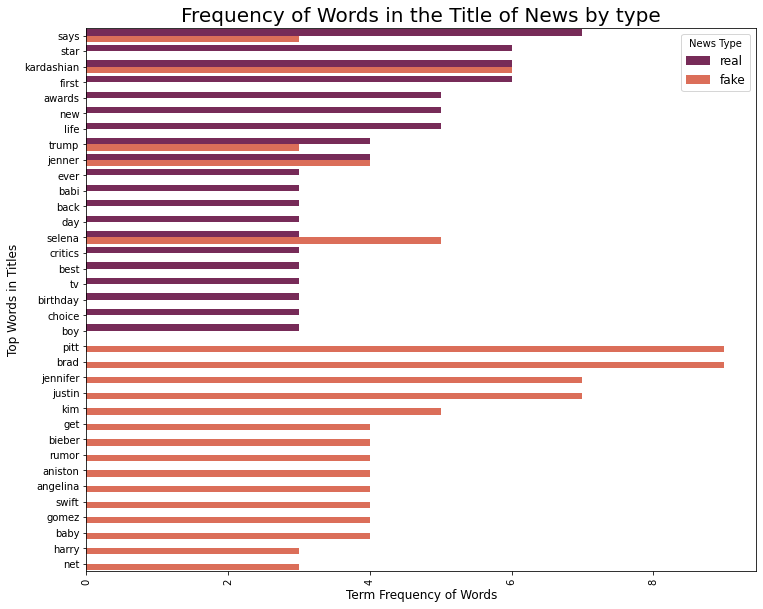

In [248]:
# let's plot them
plt.figure(figsize=(12,10))
sns.barplot(y=conc1_top_20.index,x='sum',data=conc1_top_20,hue='type',palette='rocket')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Titles',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Title of News by type',fontsize=20)
plt.show()

In [112]:
# let's do the same process for the body of real and fake top 30

# for the real dataqet
print("real")
print(df_real['text'].shape)
#type(df_fake['title'])

top_Breal_30=count_words(df_real['text']).head(20)

# for the fake dataqet
print ("fake")
print(df_fake['text'].shape)
#type(df_fake['title'])

top_Bfake_30=count_words(df_fake['text']).head(20)

real
(101,)
(101, 12531)
fake
(92,)
(92, 13962)


In [218]:
# merging the fake and real top 20

#let's drop the useless columns, those not the sum
top_Bfake_30.drop(list(range(0,df_fake['title'].shape[0])),axis=1,inplace=True)
top_Breal_30.drop(list(range(0,df_real['title'].shape[0])),axis=1,inplace=True)

# adding a category column
top_Breal_30['type']='real'
top_Bfake_30['type']='fake'
# concat
conc1_top_20_b=pd.concat([top_Breal_30,top_Bfake_30])

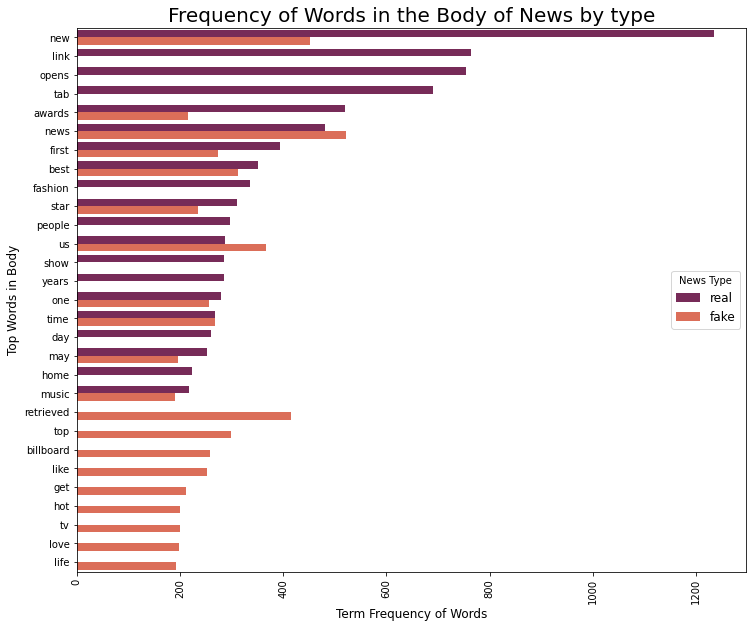

In [116]:
# let's plot them
plt.figure(figsize=(12,10))
sns.barplot(y=conc1_top_20_b.index,x='sum',data=conc1_top_20_b,hue='type',palette='rocket')
plt.xticks(rotation=90)
plt.xlabel('Term Frequency of Words',fontsize=12)
plt.ylabel('Top Words in Body',fontsize=12)
plt.legend(title='News Type',fontsize=12)
plt.title('Frequency of Words in the Body of News by type',fontsize=20)
plt.show()

In [117]:
# let's analyse the length of the title and body text
data['title_length']=data['title'].apply(lambda x: len(x))
data['body_length']=data['text'].apply(lambda x: len(x))

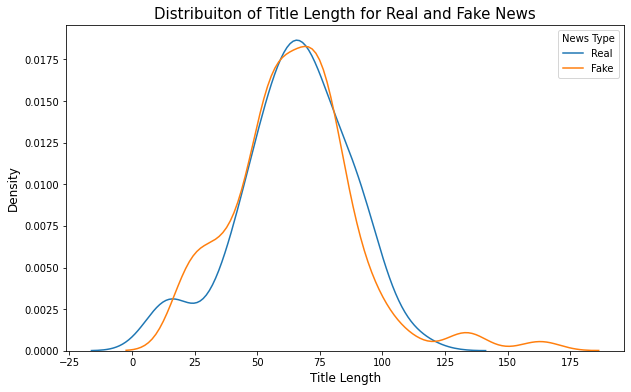

In [118]:
# plotting title length
plt.figure(figsize=(10,6))
sns.kdeplot(data[data['type']=='real']['title_length'])
sns.kdeplot(data[data['type']=='fake']['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Title Length for Real and Fake News',fontsize=15)
plt.show()

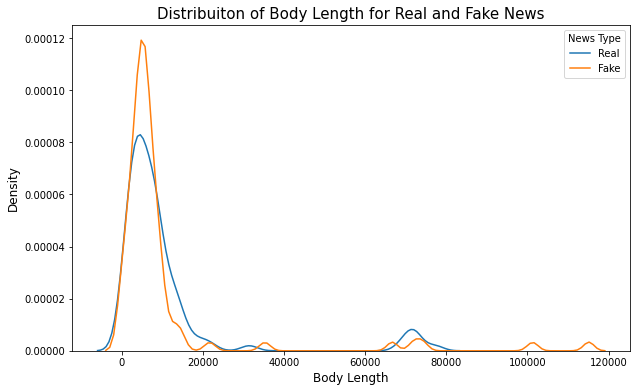

In [119]:
# plotting title length
plt.figure(figsize=(10,6))
sns.kdeplot(data[data['type']=='real']['body_length'])
sns.kdeplot(data[data['type']=='fake']['body_length'])
plt.xlabel('Body Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribuiton of Body Length for Real and Fake News',fontsize=15)
plt.show()

### Classification
#### Random Forest with the tdf of the body only

In [120]:
yb= data['type']

In [121]:
Xb= [preprocess_text(line)for line in data['text']]


In [122]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=0)

In [123]:
print(len(Xb_train),len(yb_train), len(Xb_test), len(yb_test) )

135 135 58 58


In [124]:
def pipeL_rf():
    pp=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',RandomForestClassifier())
        ])
    return pp


In [129]:
pp=pipeL_rf()
pp.fit(Xb_train,yb_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [130]:
# predicting the articles in the test set
predictions1=pp.predict(Xb_test)

In [131]:
print(confusion_matrix(yb_test, predictions1))
print('\n')
print(classification_report(yb_test, predictions1))

[[18  9]
 [11 20]]


              precision    recall  f1-score   support

        fake       0.62      0.67      0.64        27
        real       0.69      0.65      0.67        31

    accuracy                           0.66        58
   macro avg       0.66      0.66      0.65        58
weighted avg       0.66      0.66      0.66        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


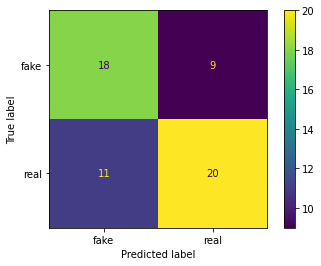

In [132]:
plot_confusion_matrix(pp, Xb_test, yb_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.71      0.89      0.79        27
        real       0.88      0.68      0.76        31

    accuracy                           0.78        58
   macro avg       0.79      0.78      0.78        58
weighted avg       0.80      0.78      0.77        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


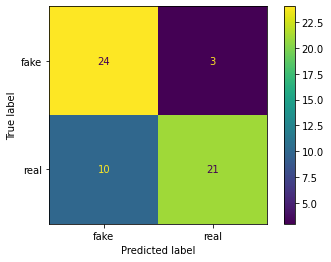

In [134]:
# let's see without text preprocessing
Xb1= data['text']
Xb1_train, Xb1_test, yb1_train, yb1_test = train_test_split(Xb1, yb, test_size=0.3, random_state=0)
# new pipeline instance
pp=pipeL_rf()
pp.fit(Xb1_train,yb1_train)
# predicting the articles in the test set
predictions2=pp.predict(Xb1_test)
print(classification_report(yb1_test, predictions2))
plot_confusion_matrix(pp, Xb1_test, yb1_test)  
plt.show()

In [ ]:
# training the model without preprocessing is giving less accuracy than with pre processing, so we will keep the pre precess
# let's try the prediction based on title only



In [135]:

yt=data['type']
Xt= [preprocess_text(line)for line in data['title']]
Xt_train, Xt_test, yt_train, yt_test = train_test_split(Xt, yt, test_size=0.3, random_state=0)



              precision    recall  f1-score   support

        fake       0.88      0.26      0.40        27
        real       0.60      0.97      0.74        31

    accuracy                           0.64        58
   macro avg       0.74      0.61      0.57        58
weighted avg       0.73      0.64      0.58        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


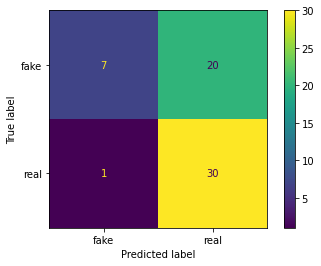

In [138]:
pp=pipeL_rf()
pp.fit(Xt_train,yt_train)
predictionstt=pp.predict(Xt_test)
print(classification_report(yt_test, predictionstt))
plot_confusion_matrix(pp, Xt_test, yt_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.60      0.44      0.51        27
        real       0.61      0.74      0.67        31

    accuracy                           0.60        58
   macro avg       0.60      0.59      0.59        58
weighted avg       0.60      0.60      0.59        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


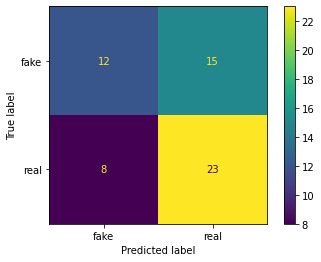

In [262]:
# let's see without text preprocessing
Xt1= data['title']
yt1= data['type']
Xt1_train, Xt1_test, yt1_train, yt1_test = train_test_split(Xt1, yt1, test_size=0.3, random_state=0)
pp=pipeL_rf()
pp.fit(Xt1_train,yt1_train)
# predicting the articles in the test set
predictions2=pp.predict(Xt1_test)
print(classification_report(yt1_test, predictions2))
plot_confusion_matrix(pp, Xt1_test, yt1_test)  
plt.show()

In [147]:
# this is not too good, especially for the fake news that are more classified as real. this can be seen in the recall of fake as well

# ppbt=Pipeline([
#    ('bow',CountVectorizer()),
#    ('tfidf',TfidfTransformer()),
#    ('classifier',RandomForestClassifier())
#    ])

In [143]:
# prediction using both title and body

data['title_text']=data['title']+': ' +data['text']


In [144]:

ybt=data['type']
Xbt= [preprocess_text(line)for line in data['title_text']]
Xbt_train, Xbt_test, ybt_train, ybt_test = train_test_split(Xbt, ybt, test_size=0.3, random_state=0)

              precision    recall  f1-score   support

        fake       0.61      0.74      0.67        27
        real       0.72      0.58      0.64        31

    accuracy                           0.66        58
   macro avg       0.66      0.66      0.65        58
weighted avg       0.67      0.66      0.65        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


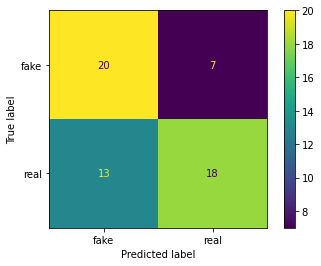

In [263]:

ppbt=pipeL_rf()
ppbt.fit(Xbt_train,ybt_train)
predictionstt=ppbt.predict(Xbt_test)

print(classification_report(ybt_test, predictionstt))
plot_confusion_matrix(ppbt, Xbt_test, ybt_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.65      0.81      0.72        27
        real       0.79      0.61      0.69        31

    accuracy                           0.71        58
   macro avg       0.72      0.71      0.71        58
weighted avg       0.72      0.71      0.71        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


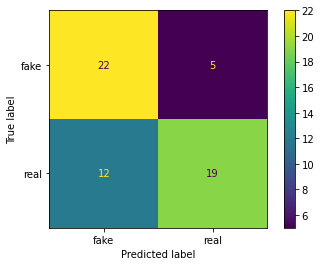

In [152]:
# let's see without text preprocessing
Xbt1= data['title_text']
ybt1= data['type']
Xbt1_train, Xbt1_test, ybt1_train, ybt1_test = train_test_split(Xbt1, ybt1, test_size=0.3, random_state=0)
ppbt=pipeL_rf()
ppbt.fit(Xbt1_train,ybt1_train)
# predicting the articles in the test set
predictions2=ppbt.predict(Xbt1_test)
print(classification_report(ybt1_test, predictions2))
plot_confusion_matrix(ppbt, Xbt1_test, ybt1_test)  
plt.show()

In [153]:
# let's try to predict with a weight of 2 more on the body words

data['title_text2']=': ' +data['title']+data['text']+': ' +data['text']

In [158]:
ybt2= data['type']
Xbt2= [preprocess_text(line)for line in data['title_text2']]


              precision    recall  f1-score   support

        fake       0.69      0.74      0.71        27
        real       0.76      0.71      0.73        31

    accuracy                           0.72        58
   macro avg       0.72      0.73      0.72        58
weighted avg       0.73      0.72      0.72        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


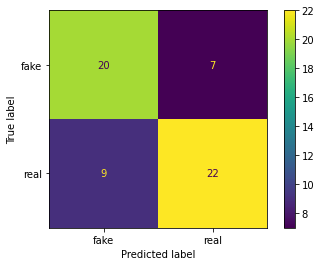

In [178]:
Xbt2_train, Xbt2_test, ybt2_train, ybt2_test = train_test_split(Xbt2, ybt2, test_size=0.3, random_state=0)
ppbt=pipeL_rf()
ppbt.fit(Xbt2_train,ybt2_train)
predictionstt=ppbt.predict(Xbt2_test)

print(classification_report(ybt2_test, predictionstt))
plot_confusion_matrix(ppbt, Xbt2_test, ybt2_test)  
plt.show()

the best up here was 76

              precision    recall  f1-score   support

        fake       0.71      0.81      0.76        27
        real       0.81      0.71      0.76        31

    accuracy                           0.76        58
   macro avg       0.76      0.76      0.76        58
weighted avg       0.77      0.76      0.76        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


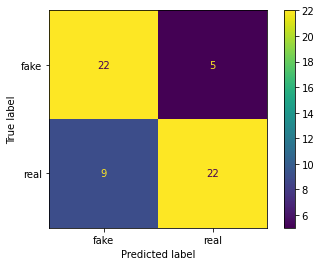

In [271]:
# let's see without text preprocessing
Xbt21= data['title_text2']
ybt21= data['type']
Xbt21_train, Xbt21_test, ybt21_train, ybt21_test = train_test_split(Xbt21, ybt21, test_size=0.3, random_state=0)
ppbt=pipeL_rf()
ppbt.fit(Xbt21_train,ybt21_train)
# predicting the articles in the test set
predictions2=ppbt.predict(Xbt21_test)
print(classification_report(ybt21_test, predictions2))
plot_confusion_matrix(ppbt, Xbt21_test, ybt21_test)  
plt.show()


#### XG boosting classifier


In [180]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import xgboost


In [83]:
print(xgboost.__version__)

0.80


In [84]:
# couldn't run the version 1.5; kernel would continuously crash

In [181]:
def pp_xgb(rs=0,ss=0.7):
    xgb = XGBClassifier(random_state=rs, seed=2, colsample_bytree=0.6, subsample=ss)
    ppxg=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier', xgb )
        ])
    return ppxg

In [182]:
#pipeline = Pipeline([
#  ("vectorizer", TfidfVectorizer()),
#  ("classifier", XGBClassifier())
#])

ppxg=pp_xgb()

In [183]:
ppxg.fit(Xt_train,yt_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier',
                 XGBClassifier(colsample_bytree=0.6, seed=2, subsample=0.7))])

In [184]:
# title preprocessed
predictionsxg=ppxg.predict(Xt_test)

              precision    recall  f1-score   support

        fake       0.86      0.22      0.35        27
        real       0.59      0.97      0.73        31

    accuracy                           0.62        58
   macro avg       0.72      0.59      0.54        58
weighted avg       0.71      0.62      0.56        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


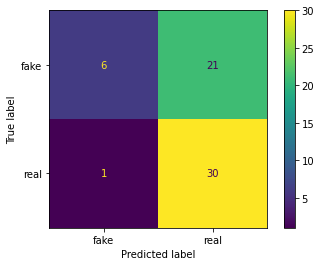

In [185]:
print(classification_report(yt_test, predictionsxg))
plot_confusion_matrix(ppxg, Xt_test, yt_test)  
plt.show()

              precision    recall  f1-score   support

        fake       0.49      0.67      0.56        27
        real       0.57      0.39      0.46        31

    accuracy                           0.52        58
   macro avg       0.53      0.53      0.51        58
weighted avg       0.53      0.52      0.51        58



/Users/vickyyounang/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


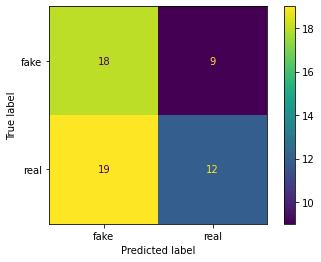

In [273]:
# title without preprocessing
ppxg=pp_xgb()
ppxg.fit(Xt1_train,yt1_train)

predictionsxg=ppxg.predict(Xt1_test)

print(classification_report(yt1_test, predictionsxg))
plot_confusion_matrix(ppxg, Xt1_test, yt1_test)  
plt.show()


In [274]:
# body dataset PREPROCESSD 
ppxg=pp_xgb()
ppxg.fit(Xb_train,yb_train)

predictionsxg=ppxg.predict(Xb_test)

print("body dataset PREPROCESSD ")
print(classification_report(yb_test, predictionsxg))
#plot_confusion_matrix(ppxg, Xb_test, yb_test)  
#plt.show()

body dataset PREPROCESSD 
              precision    recall  f1-score   support

        fake       0.53      0.67      0.59        27
        real       0.62      0.48      0.55        31

    accuracy                           0.57        58
   macro avg       0.58      0.58      0.57        58
weighted avg       0.58      0.57      0.57        58



In [275]:
# body dataset Non preprocessed
ppxg=pp_xgb()
ppxg.fit(Xb1_train,yb1_train)

predictionsxg=ppxg.predict(Xb1_test)

print("body dataset not PREPROCESSD")
print(classification_report(yb1_test, predictionsxg))
#plot_confusion_matrix(ppxg, Xb1_test, yb1_test)  
#plt.show()

body dataset not PREPROCESSD
              precision    recall  f1-score   support

        fake       0.61      0.74      0.67        27
        real       0.72      0.58      0.64        31

    accuracy                           0.66        58
   macro avg       0.66      0.66      0.65        58
weighted avg       0.67      0.66      0.65        58



In [196]:
# body and title dataset PREPROCESSED
ppxg=pp_xgb()
ppxg.fit(Xbt_train,ybt_train)

predictionsxg=ppxg.predict(Xbt_test)

print("body and title  dataset PREPROCESSD ")
print(classification_report(ybt_test, predictionsxg))
#plot_confusion_matrix(ppxg, Xbt_test, ybt_test)  
#plt.show()

body and title  dataset PREPROCESSD 
              precision    recall  f1-score   support

        fake       0.60      0.78      0.68        27
        real       0.74      0.55      0.63        31

    accuracy                           0.66        58
   macro avg       0.67      0.66      0.65        58
weighted avg       0.67      0.66      0.65        58



In [199]:
# body and title dataset NON PREPROCESSD
ppxg=pp_xgb()
ppxg.fit(Xbt1_train,ybt1_train)

predictionsxg=ppxg.predict(Xbt1_test)

print("body and title  dataset non PREPROCESSD ")
print(classification_report(ybt1_test, predictionsxg))
#plot_confusion_matrix(ppxg, Xbt1_test, ybt1_test)  
#plt.show()

body and title  dataset non PREPROCESSD 
              precision    recall  f1-score   support

        fake       0.69      0.74      0.71        27
        real       0.76      0.71      0.73        31

    accuracy                           0.72        58
   macro avg       0.72      0.73      0.72        58
weighted avg       0.73      0.72      0.72        58



In [201]:
# body and title dataset modified preprocessed
ppxg=pp_xgb()
ppxg.fit(Xbt2_train,ybt2_train)

predictionsxg=ppxg.predict(Xbt2_test)

print("body and title dataset modified preprocessed")
print(classification_report(ybt2_test, predictionsxg))
#plot_confusion_matrix(ppxg, Xbt2_test, ybt2_test)  
#plt.show()

body and title dataset modified preprocessed
              precision    recall  f1-score   support

        fake       0.58      0.70      0.63        27
        real       0.68      0.55      0.61        31

    accuracy                           0.62        58
   macro avg       0.63      0.63      0.62        58
weighted avg       0.63      0.62      0.62        58



In [203]:
# body and title dataset modified NON preprocessed
ppxg=pp_xgb()
ppxg.fit(Xbt21_train,ybt21_train)

predictionsxg=ppxg.predict(Xbt21_test)
print('body and title dataset modified non preprocessed')
print(classification_report(ybt21_test, predictionsxg))
#plot_confusion_matrix(ppxg, Xbt21_test, ybt21_test)  
#plt.show()

body and title dataset modified non preprocessed
              precision    recall  f1-score   support

        fake       0.64      0.78      0.70        27
        real       0.76      0.61      0.68        31

    accuracy                           0.69        58
   macro avg       0.70      0.70      0.69        58
weighted avg       0.70      0.69      0.69        58



In [204]:
# tuning parameter:

ppxg.named_steps['classifier'].get_params()


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 2,
 'silent': True,
 'subsample': 0.7}

In [276]:
# those are the base parameters in the xgboost classifier, let's. tune them
# changing the number of estimators
# definition of parameter grid to scan through
param_grid = {
     'classifier__n_estimators': [100,200,300,500],
     'classifier__random_state':[0,42],
     'classifier__colsample_bytree': [0.6],
     'classifier__subsample': [0.5, 0.6, 0.7],
    'classifier__learning_rate':[0.05, 0.01]
}


In [277]:
#
# grid search cross validation instantiation
ppxg=pp_xgb()
grid_search = GridSearchCV(estimator = ppxg, param_grid = param_grid, 
                          cv = 5, n_jobs = 1, verbose = 0, return_train_score=True)
#hyperparameter fitting
grid_search.fit(Xt_train, yt_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier',
                                        XGBClassifier(colsample_bytree=0.6,
                                                      seed=2,
                                                      subsample=0.7))]),
             n_jobs=1,
             param_grid={'classifier__colsample_bytree': [0.6],
                         'classifier__learning_rate': [0.05, 0.01],
                         'classifier__n_estimators': [100, 200, 300, 500],
                         'classifier__random_state': [0, 42],
                         'classifier__subsample': [0.5, 0.6, 0.7]},
             return_train_score=True)

In [278]:
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

train scores
[0.56296296 0.58148148 0.58703704 0.56296296 0.58148148 0.58703704
 0.58148148 0.5962963  0.5962963  0.58148148 0.5962963  0.5962963
 0.58333333 0.58888889 0.59444444 0.58333333 0.58888889 0.59444444
 0.57777778 0.60185185 0.61481481 0.57777778 0.60185185 0.61481481
 0.5462963  0.56851852 0.57777778 0.5462963  0.56851852 0.57777778
 0.54814815 0.56851852 0.58333333 0.54814815 0.56851852 0.58333333
 0.56111111 0.57777778 0.58148148 0.56111111 0.57777778 0.58148148
 0.56666667 0.57962963 0.58703704 0.56666667 0.57962963 0.58703704]
validation scores
[0.51851852 0.54814815 0.52592593 0.51851852 0.54814815 0.52592593
 0.54814815 0.51111111 0.4962963  0.54814815 0.51111111 0.4962963
 0.54814815 0.54814815 0.54074074 0.54814815 0.54814815 0.54074074
 0.54814815 0.48888889 0.48888889 0.54814815 0.48888889 0.48888889
 0.51851852 0.53333333 0.54814815 0.51851852 0.53333333 0.54814815
 0.51851852 0.54074074 0.56296296 0.51851852 0.54074074 0.56296296
 0.53333333 0.54814815 0.5629629

In [279]:

grid_search.best_params_

{'classifier__colsample_bytree': 0.6,
 'classifier__learning_rate': 0.01,
 'classifier__n_estimators': 200,
 'classifier__random_state': 0,
 'classifier__subsample': 0.7}

In [280]:
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xt_test)

print("title data preprocessed")
print(classification_report(yt_test, predictionsxg))
#plot_confusion_matrix(ppxg_test, Xt_test, yt_test)  
#plt.show()
#hyperparameter fitting


grid_search.fit(Xt1_train, yt1_train)
ppxg_test = grid_search.best_estimator_
predictionsxg1=ppxg_test.predict(Xt1_test)

print("title data non preprocessed")
print(classification_report(yt1_test, predictionsxg1))


title data preprocessed
              precision    recall  f1-score   support

        fake       0.83      0.19      0.30        27
        real       0.58      0.97      0.72        31

    accuracy                           0.60        58
   macro avg       0.71      0.58      0.51        58
weighted avg       0.70      0.60      0.53        58

title data non preprocessed
              precision    recall  f1-score   support

        fake       0.53      0.67      0.59        27
        real       0.62      0.48      0.55        31

    accuracy                           0.57        58
   macro avg       0.58      0.58      0.57        58
weighted avg       0.58      0.57      0.57        58



In [281]:
# body data PREPROCEDSSDE

grid_search.fit(Xb_train, yb_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

print(grid_search.best_params_)

# creating a classifier with the best param to predict the test set and see if we are not overfiiting

ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xb_test)

print(classification_report(yb_test, predictionsxg))
#plot_confusion_matrix(ppxg_test, Xb_test, yb_test)  
#plt.show()


grid_search.fit(Xb1_train, yb1_train)
ppxg_test1 = grid_search.best_estimator_

predictionsxg1=ppxg_test1.predict(Xb1_test)

print("title data non preprocessed")
print(classification_report(yb1_test, predictionsxg1))

train scores
[0.9962963  0.99814815 0.9962963  0.9962963  0.99814815 0.9962963
 1.         1.         1.         1.         1.         1.
 0.99814815 1.         1.         0.99814815 1.         1.
 1.         1.         1.         1.         1.         1.
 0.96111111 0.96666667 0.97777778 0.96111111 0.96666667 0.97777778
 0.98333333 0.97962963 0.98703704 0.98333333 0.97962963 0.98703704
 0.98703704 0.98888889 0.99444444 0.98703704 0.98888889 0.99444444
 0.99814815 0.99814815 0.99814815 0.99814815 0.99814815 0.99814815]
validation scores
[0.62222222 0.62222222 0.61481481 0.62222222 0.62222222 0.61481481
 0.62222222 0.61481481 0.60740741 0.62222222 0.61481481 0.60740741
 0.62222222 0.61481481 0.60740741 0.62222222 0.61481481 0.60740741
 0.61481481 0.60740741 0.61481481 0.61481481 0.60740741 0.61481481
 0.62962963 0.63703704 0.62222222 0.62962963 0.63703704 0.62222222
 0.64444444 0.64444444 0.62222222 0.64444444 0.64444444 0.62222222
 0.65185185 0.64444444 0.62222222 0.65185185 0.64444444

In [215]:
# text and title together PREPROCCESDDES

grid_search.fit(Xbt_train, ybt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

print(grid_search.best_params_)

# creating a classifier with the best param to predict the test set and see if we are not overfiiting
ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xbt_test)
print("title and text data  preprocessed")

print(classification_report(ybt_test, predictionsxg))
#plot_confusion_matrix(ppxg_test, Xbt_test, ybt_test)  
#plt.show()


grid_search.fit(Xbt1_train, ybt1_train)
ppxg_test1 = grid_search.best_estimator_

predictionsxg1=ppxg_test1.predict(Xbt1_test)

print("title and text data non preprocessed")
print(classification_report(ybt1_test, predictionsxg1))




train scores
[0.99814815 1.         1.         0.99814815 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]
validation scores
[0.6        0.62962963 0.61481481 0.6        0.62962963 0.61481481
 0.59259259 0.65925926 0.62962963 0.59259259 0.65925926 0.62962963
 0.6        0.63703704 0.62222222 0.6        0.63703704 0.62222222
 0.60740741 0.63703704 0.63703704 0.60740741 0.63703704 0.63703704]
{'classifier__colsample_bytree': 0.6, 'classifier__n_estimators': 200, 'classifier__random_state': 0, 'classifier__subsample': 0.6}
title and text data  preprocessed
              precision    recall  f1-score   support

        fake       0.57      0.74      0.65        27
        real       0.70      0.52      0.59        31

    accuracy                           0.62        58
   macro avg       0.63      0.63      0.62        58
weighted avg     

In [282]:
# text and title modified 

grid_search.fit(Xbt2_train, ybt2_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])

print(grid_search.best_params_)

# creating a classifier with the best param to predict the test set and see if we are not overfiiting
ppxg_test = grid_search.best_estimator_
predictionsxg=ppxg_test.predict(Xbt2_test)

print(classification_report(ybt2_test, predictionsxg))
#plot_confusion_matrix(ppxg_test, Xbt2_test, ybt2_test)  
#plt.show()


grid_search.fit(Xbt2_train, ybt2_train)
ppxg_test1 = grid_search.best_estimator_

predictionsxg1=ppxg_test1.predict(Xbt2_test)

print("title and text data non preprocessed")
print(classification_report(ybt2_test, predictionsxg1))



train scores
[0.98888889 0.99814815 1.         0.98888889 0.99814815 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.95555556 0.96481481 0.97592593 0.95555556 0.96481481 0.97592593
 0.97962963 0.98703704 0.98888889 0.97962963 0.98703704 0.98888889
 0.98888889 0.99259259 0.99814815 0.98888889 0.99259259 0.99814815
 0.99259259 1.         1.         0.99259259 1.         1.        ]
validation scores
[0.65185185 0.61481481 0.62222222 0.65185185 0.61481481 0.62222222
 0.65185185 0.62962963 0.63703704 0.65185185 0.62962963 0.63703704
 0.65925926 0.65185185 0.63703704 0.65925926 0.65185185 0.63703704
 0.66666667 0.62222222 0.66666667 0.66666667 0.62222222 0.66666667
 0.6        0.60740741 0.60740741 0.6        0.60740741 0.60740741
 0.64444444 0.60740741 0.61481481 0.64444444 0.60740741 0.61481481
 0.64444444 0.63703704 0.62222222 0.64444444 0.63703704 0.6222

### PASSIVE Agressive Classifier
LET4s try the classification with the passive aggressive classifier

In [219]:
def pp_pass():
    pp_pa=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',PassiveAggressiveClassifier())
        ])
    return pp_pa

In [222]:
# on the title data preprocssd
pp_pa=pp_pass()
pp_pa.fit(Xt_train,yt_train)
predictionstt=pp_pa.predict(Xt_test)

print("title data preprocessed")
print(classification_report(yt_test, predictionstt))
#plot_confusion_matrix(pp_pa, Xt_test, yt_test)  
#plt.show()

# on the title data
pp_pa = pp_pass()
pp_pa.fit(Xt1_train,yt1_train)
predictionstt1=pp_pa.predict(Xt1_test)

print("title data non preprocessed")
print(classification_report(yt1_test, predictionstt1))
#plot_confusion_matrix(pp_pa, Xt1_test, yt1_test)  
#plt.show()


title data preprocessed
              precision    recall  f1-score   support

        fake       0.68      0.63      0.65        27
        real       0.70      0.74      0.72        31

    accuracy                           0.69        58
   macro avg       0.69      0.69      0.69        58
weighted avg       0.69      0.69      0.69        58

title data non preprocessed
              precision    recall  f1-score   support

        fake       0.61      0.52      0.56        27
        real       0.63      0.71      0.67        31

    accuracy                           0.62        58
   macro avg       0.62      0.61      0.61        58
weighted avg       0.62      0.62      0.62        58



In [225]:
# on the body data
pp_pa=pp_pass()
pp_pa.fit(Xb_train,yb_train)
predictionsbb=pp_pa.predict(Xb_test)

print("body data  preprocessed")
print(classification_report(yb_test, predictionsbb))
#plot_confusion_matrix(pp_pa, Xb_test, yb_test)  
#plt.show()

# on the BODY data
pp_pa = pp_pass()
pp_pa.fit(Xb1_train,yb1_train)
predictionstt1=pp_pa.predict(Xb1_test)

print("body data non preprocessed")
print(classification_report(yb1_test, predictionstt1))
#plot_confusion_matrix(pp_pa, Xb1_test, yb1_test)  
#plt.show()

body data  preprocessed
              precision    recall  f1-score   support

        fake       0.61      0.74      0.67        27
        real       0.72      0.58      0.64        31

    accuracy                           0.66        58
   macro avg       0.66      0.66      0.65        58
weighted avg       0.67      0.66      0.65        58

body data non preprocessed
              precision    recall  f1-score   support

        fake       0.74      0.63      0.68        27
        real       0.71      0.81      0.76        31

    accuracy                           0.72        58
   macro avg       0.73      0.72      0.72        58
weighted avg       0.73      0.72      0.72        58



In [228]:
# on the body and title mixed data
pp_pa=pp_pass()
pp_pa.fit(Xbt_train,ybt_train)
predictionsbt=pp_pa.predict(Xbt_test)

print("body and title data  preprocessed")
print(classification_report(ybt_test, predictionsbt))
#plot_confusion_matrix(pp_pa, Xbt_test, ybt_test)  
#plt.show()

# on the BODY @ title data
pp_pa = pp_pass()
pp_pa.fit(Xbt1_train,ybt1_train)
predictionstt1=pp_pa.predict(Xbt1_test)

print("body and title data non preprocessed")
print(classification_report(ybt1_test, predictionstt1))
#plot_confusion_matrix(pp_pa, Xbt1_test, ybt1_test)  
#plt.show()

body and title data  preprocessed
              precision    recall  f1-score   support

        fake       0.58      0.78      0.67        27
        real       0.73      0.52      0.60        31

    accuracy                           0.64        58
   macro avg       0.66      0.65      0.64        58
weighted avg       0.66      0.64      0.63        58

body and title data non preprocessed
              precision    recall  f1-score   support

        fake       0.65      0.63      0.64        27
        real       0.69      0.71      0.70        31

    accuracy                           0.67        58
   macro avg       0.67      0.67      0.67        58
weighted avg       0.67      0.67      0.67        58



In [236]:
# text and title modified
pp_pa=pp_pass()
pp_pa.fit(Xbt2_train,ybt2_train)
predictionsbt=pp_pa.predict(Xbt2_test)

print("body and title data modified  preprocessed")
print(classification_report(ybt2_test, predictionsbt))
#plot_confusion_matrix(pp_pa, Xbt2_test, ybt2_test)  
#plt.show()

# on the BODY @ title data MODIFIED
pp_pa = pp_pass()
pp_pa.fit(Xbt21_train,ybt21_train)
predictionstt1=pp_pa.predict(Xbt21_test)

print("body and title data modified non preprocessed")
print(classification_report(ybt21_test, predictionstt1))
#plot_confusion_matrix(pp_pa, Xbt21_test, ybt21_test)  
#plt.show()

body and title data modified  preprocessed
              precision    recall  f1-score   support

        fake       0.57      0.74      0.65        27
        real       0.70      0.52      0.59        31

    accuracy                           0.62        58
   macro avg       0.63      0.63      0.62        58
weighted avg       0.64      0.62      0.62        58

body and title data modified non preprocessed
              precision    recall  f1-score   support

        fake       0.74      0.63      0.68        27
        real       0.71      0.81      0.76        31

    accuracy                           0.72        58
   macro avg       0.73      0.72      0.72        58
weighted avg       0.73      0.72      0.72        58



In [253]:
pp_pa.get_params()

{'memory': None,
 'steps': [('bow', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('classifier', PassiveAggressiveClassifier())],
 'verbose': False,
 'bow': CountVectorizer(),
 'tfidf': TfidfTransformer(),
 'classifier': PassiveAggressiveClassifier(),
 'bow__analyzer': 'word',
 'bow__binary': False,
 'bow__decode_error': 'strict',
 'bow__dtype': numpy.int64,
 'bow__encoding': 'utf-8',
 'bow__input': 'content',
 'bow__lowercase': True,
 'bow__max_df': 1.0,
 'bow__max_features': None,
 'bow__min_df': 1,
 'bow__ngram_range': (1, 1),
 'bow__preprocessor': None,
 'bow__stop_words': None,
 'bow__strip_accents': None,
 'bow__token_pattern': '(?u)\\b\\w\\w+\\b',
 'bow__tokenizer': None,
 'bow__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'classifier__C': 1.0,
 'classifier__average': False,
 'classifier__class_weight': None,
 'classifier__early_stopping': False,
 'classifier__fit_intercept': True,
 'classi

In [ ]:
# PASSIVE AGRESSIVE C TUNING

# parameters tuning of the passive agressive classifier ( c, reg param, max iter and tolerance )



In [254]:
param_grid2 = {
     'classifier__C': [0.5,0.8],
     'classifier__random_state':[0],
     'classifier__tol': [0.001,0.0001],
     'classifier__max_iter':[1500]
     #'classifier__colsample_bytree': [0.6],
     #'classifier__subsample': [0.5, 0.6, 0.7]
}

In [256]:
# grid search cross validation instantiation
pp_pa=pp_pass()
grid_search = GridSearchCV(estimator = pp_pa, param_grid = param_grid2, 
                          cv = 10, n_jobs = 1, verbose = 0, return_train_score=True)

In [257]:
# test on title processed
print(" ")
print("title data")
grid_search.fit(Xt_train, yt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xt_test)
print(classification_report(yt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print(" ")
print("body data")
# body preprocesszd
grid_search.fit(Xb_train, yb_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xb_test)
print(classification_report(yb_test, predictionsrf))

print(" ")
print("body and title data")
# # text and title processed
grid_search.fit(Xbt_train, ybt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xbt_test)
print(classification_report(ybt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()

print(" ")
print("body + body and title data")
 # text and title processed modified
grid_search.fit(Xbt2_train, ybt2_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xbt2_test)
print(classification_report(ybt2_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()


 
title data
train scores
[1. 1. 1. 1.]
validation scores
[0.60714286 0.60714286 0.60714286 0.60714286]
{'classifier__C': 0.5, 'classifier__max_iter': 1500, 'classifier__random_state': 0, 'classifier__tol': 0.001}
              precision    recall  f1-score   support

        fake       0.68      0.63      0.65        27
        real       0.70      0.74      0.72        31

    accuracy                           0.69        58
   macro avg       0.69      0.69      0.69        58
weighted avg       0.69      0.69      0.69        58

 
body data
train scores
[1.         1.         0.99917355 1.        ]
validation scores
[0.64340659 0.65879121 0.65164835 0.65879121]
{'classifier__C': 0.5, 'classifier__max_iter': 1500, 'classifier__random_state': 0, 'classifier__tol': 0.0001}
              precision    recall  f1-score   support

        fake       0.55      0.63      0.59        27
        real       0.63      0.55      0.59        31

    accuracy                           0.59      

In [260]:
# trying passive without CV
# grid search cross validation instantiation
pp_pa=pp_pass()
grid_search = GridSearchCV(estimator = pp_pa, param_grid = param_grid2, 
                           n_jobs = 1, verbose = 0, return_train_score=True)

In [261]:
# test on title processed
print(" ")
print("title data")
grid_search.fit(Xt_train, yt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xt_test)
print(classification_report(yt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print(" ")
print("body data")
# body preprocesszd
grid_search.fit(Xb_train, yb_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xb_test)
print(classification_report(yb_test, predictionsrf))

print(" ")
print("body and title data")
# # text and title processed
grid_search.fit(Xbt_train, ybt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xbt_test)
print(classification_report(ybt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()

print(" ")
print("body + body and title data")
 # text and title processed modified
grid_search.fit(Xbt2_train, ybt2_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pppa_test = grid_search.best_estimator_
predictionsrf=pppa_test.predict(Xbt2_test)
print(classification_report(ybt2_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()


 
title data
train scores
[1. 1. 1. 1.]
validation scores
[0.6 0.6 0.6 0.6]
{'classifier__C': 0.5, 'classifier__max_iter': 1500, 'classifier__random_state': 0, 'classifier__tol': 0.001}
              precision    recall  f1-score   support

        fake       0.68      0.63      0.65        27
        real       0.70      0.74      0.72        31

    accuracy                           0.69        58
   macro avg       0.69      0.69      0.69        58
weighted avg       0.69      0.69      0.69        58

 
body data
train scores
[1. 1. 1. 1.]
validation scores
[0.65925926 0.65925926 0.66666667 0.66666667]
{'classifier__C': 0.8, 'classifier__max_iter': 1500, 'classifier__random_state': 0, 'classifier__tol': 0.001}
              precision    recall  f1-score   support

        fake       0.57      0.63      0.60        27
        real       0.64      0.58      0.61        31

    accuracy                           0.60        58
   macro avg       0.60      0.61      0.60        58
we

#### Random Forest recall improvement
we noticed that, for the classification based on title, almost all classifiers have a poor recall score on real and precision on fake data and vice versa. RF also has poor scores for classification based on body for eg as well.
we will try to increase the recall on real news 

In [237]:
# RF parameter tuning
# let's change n_estimators to 200 and random state to 0
def pipeL_rf_200():
    pp=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',RandomForestClassifier(n_estimators=200, random_state=0 ))
        ])
    return pp

In [238]:
# test on title processed
print("title")
pp200=pipeL_rf_200()
pp200.fit(Xt_train,yt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xt_test)
print(classification_report(yt_test, predictions2))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print("body")
# body preprocesszd
pp200=pipeL_rf_200()
pp200.fit(Xb_train,yb_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xb_test)
print(classification_report(yb_test, predictions2))
#plot_confusion_matrix(pp200, Xb_test, yb_test)  
#plt.show()

print("body and title")
# # text and title processed
pp200=pipeL_rf_200()
pp200.fit(Xbt_train,ybt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt_test)
print(classification_report(ybt_test, predictions2))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()


print("body + body and title")
 # text and title processed modified
pp200=pipeL_rf_200()
pp200.fit(Xbt2_train,ybt2_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt2_test)
print(classification_report(ybt2_test, predictions2))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()



title
              precision    recall  f1-score   support

        fake       0.86      0.22      0.35        27
        real       0.59      0.97      0.73        31

    accuracy                           0.62        58
   macro avg       0.72      0.59      0.54        58
weighted avg       0.71      0.62      0.56        58

body
              precision    recall  f1-score   support

        fake       0.61      0.81      0.70        27
        real       0.77      0.55      0.64        31

    accuracy                           0.67        58
   macro avg       0.69      0.68      0.67        58
weighted avg       0.70      0.67      0.67        58

body and title
              precision    recall  f1-score   support

        fake       0.65      0.81      0.72        27
        real       0.79      0.61      0.69        31

    accuracy                           0.71        58
   macro avg       0.72      0.71      0.71        58
weighted avg       0.72      0.71      0.71     

In [239]:
# we still feel like the precision and recall of the REAL VALues is still relatively low, ans precision of real low for the title


In [240]:
# RF parameter tuning
# let's change n_estimators to 200 and random state to 0
def pipeL_rf_300():
    pp=Pipeline([
        ('bow',CountVectorizer()),
        ('tfidf',TfidfTransformer()),
        ('classifier',RandomForestClassifier(n_estimators=300, random_state=0, class_weight='balanced_subsample' ))
        ])
    return pp


In [241]:
# test on title processed
pp200=pipeL_rf_300()
pp200.fit(Xt_train,yt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xt_test)
print("title data")
print(classification_report(yt_test, predictions2))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print("body data")
# body preprocesszd
pp200=pipeL_rf_300()
pp200.fit(Xb_train,yb_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xb_test)
print(classification_report(yb_test, predictions2))
#plot_confusion_matrix(pp200, Xb_test, yb_test)  
#plt.show()

print("body and title data")
# # text and title processed
pp200=pipeL_rf_300()
pp200.fit(Xbt_train,ybt_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt_test)
print(classification_report(ybt_test, predictions2))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()

print("body + body and title data")
 # text and title processed modified
pp200=pipeL_rf_300()
pp200.fit(Xbt2_train,ybt2_train)
# predicting the articles in the test set
predictions2=pp200.predict(Xbt2_test)
print(classification_report(ybt2_test, predictions2))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()


title data
              precision    recall  f1-score   support

        fake       0.86      0.22      0.35        27
        real       0.59      0.97      0.73        31

    accuracy                           0.62        58
   macro avg       0.72      0.59      0.54        58
weighted avg       0.71      0.62      0.56        58

body data
              precision    recall  f1-score   support

        fake       0.58      0.70      0.63        27
        real       0.68      0.55      0.61        31

    accuracy                           0.62        58
   macro avg       0.63      0.63      0.62        58
weighted avg       0.63      0.62      0.62        58

body and title data
              precision    recall  f1-score   support

        fake       0.59      0.74      0.66        27
        real       0.71      0.55      0.62        31

    accuracy                           0.64        58
   macro avg       0.65      0.64      0.64        58
weighted avg       0.65      0.64

In [ ]:
# random forest with CV
# Use the random grid to search for best hyperparameters


In [242]:
pp200.named_steps['classifier'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [244]:
a = None 
a

In [245]:
param_grid = {
     'classifier__n_estimators': [100,200,300,400],
     'classifier__random_state':[0],
     'classifier__class_weight': [a,'balanced_subsample']
     #'classifier__colsample_bytree': [0.6],
     #'classifier__subsample': [0.5, 0.6, 0.7]
}

In [246]:
# grid search cross validation instantiation
pprf=pipeL_rf()
grid_search = GridSearchCV(estimator = pprf, param_grid = param_grid, 
                          cv = 10, n_jobs = 1, verbose = 0, return_train_score=True)

In [247]:
# test on title processed
print(" ")
print("title data")
grid_search.fit(Xt_train, yt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xt_test)
print(classification_report(yt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xt_test, yt_test)  
#plt.show()

print(" ")
print("body data")
# body preprocesszd
grid_search.fit(Xb_train, yb_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xb_test)
print(classification_report(yb_test, predictionsrf))

print(" ")
print("body and title data")
# # text and title processed
grid_search.fit(Xbt_train, ybt_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xbt_test)
print(classification_report(ybt_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt_test, ybt_test)  
#plt.show()

print(" ")
print("body + body and title data")
 # text and title processed modified
grid_search.fit(Xbt2_train, ybt2_train)
print('train scores') 
print(grid_search.cv_results_['mean_train_score'])
print('validation scores') 
# validation scores
print(grid_search.cv_results_['mean_test_score'])
print(grid_search.best_params_)
# creating a classifier with the best param to predict the test set and see if we are not overfiiting
pprf_test = grid_search.best_estimator_
predictionsrf=pprf_test.predict(Xbt2_test)
print(classification_report(ybt2_test, predictionsrf))
#plot_confusion_matrix(pp200, Xbt2_test, ybt2_test)  
#plt.show()


 
title data
train scores
[1. 1. 1. 1. 1. 1. 1. 1.]
validation scores
[0.55494505 0.53296703 0.53296703 0.5478022  0.5478022  0.56263736
 0.52582418 0.53351648]
{'classifier__class_weight': 'balanced_subsample', 'classifier__n_estimators': 200, 'classifier__random_state': 0}
              precision    recall  f1-score   support

        fake       0.86      0.22      0.35        27
        real       0.59      0.97      0.73        31

    accuracy                           0.62        58
   macro avg       0.72      0.59      0.54        58
weighted avg       0.71      0.62      0.56        58

 
body data
train scores
[1. 1. 1. 1. 1. 1. 1. 1.]
validation scores
[0.62142857 0.67527473 0.63626374 0.6510989  0.63626374 0.63626374
 0.6510989  0.64450549]
{'classifier__class_weight': None, 'classifier__n_estimators': 200, 'classifier__random_state': 0}
              precision    recall  f1-score   support

        fake       0.61      0.81      0.70        27
        real       0.77      